In [3]:
import pyodbc
from sqlalchemy import create_engine
import urllib
import json
import pandas


class Connect():
    def __init__(self):
        self.credentials_file = 'C:/Users/aryan/Desktop/Python Notebooks/credentials.json'
        self.server = ''
        self.user = ''
        self.password = ''
        self.database = ''
        self.userid = '' 
        
    def getCredentials(self):
        with open(self.credentials_file) as json_file:
            data = json.load(json_file)
            self.server =   data['codes']['connectionstringdev']['server']
            self.user =     data['codes']['connectionstringdev']['user']
            self.password = data['codes']['connectionstringdev']['password']
            self.database =  data['codes']['connectionstringdev']['database']
        return self  
    
    def getModelInfo(self):
        credentials = self.getCredentials()
        server = credentials.server
        database = 'BusinessIntelligence'#credentials.database
        username = credentials.user
        password = credentials.password
        query = '''
        exec TR_CancelModelDraft
        '''        
        conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)      
        df = pandas.read_sql(query, conn)
        conn.close()
        return df
Model = Connect()
cancelreasons = Model.getModelInfo()

In [4]:
# import pandas as pd

# # load the training dataset
# cancelreasons = pd.read_csv('data/cancelreasons.csv')
cancelreasons['FindingsPerWorkorder'] = cancelreasons['FindingsPerWorkorder'].fillna(0)
cancelreasons.head()

,accountid,postalcode,estimatename,programname,cancelreasonid,DaysToCancel,programid,FindingsPerWorkorder,TotalEvents,PriceIncreases,Request,Recurring,Reinspection,Monitoring,Initial,FindingsClass,CancelClass,isCancelled
0,7816236,75115,Estimate for Pest OneTime,Pest OneTime,0,NaN,3099566,0.0,2,0,1,0,0,0,1,0,0,0
1,8306051,32822,Estimate for Pest OneTime,Pest OneTime,0,NaN,3099326,0.0,1,0,0,0,0,0,1,0,0,0
2,8238394,32763,Estimate for Ttl Cov Baiting Total Protection,Ttl Cov Baiting Total Protection,0,NaN,3099267,0.0,5,1,0,0,1,1,3,0,0,0
3,7357888,34698,Estimate for Irrigation Special Service,Irrigation Special Service,0,NaN,3099014,0.0,1,0,0,0,0,0,1,0,0,0
4,8223485,34689,Estimate for Irrigation Special Service,Irrigation Special Service,0,NaN,3098967,0.0,1,0,0,0,0,0,1,0,0,0


(499978, 7)
(499978, 4)


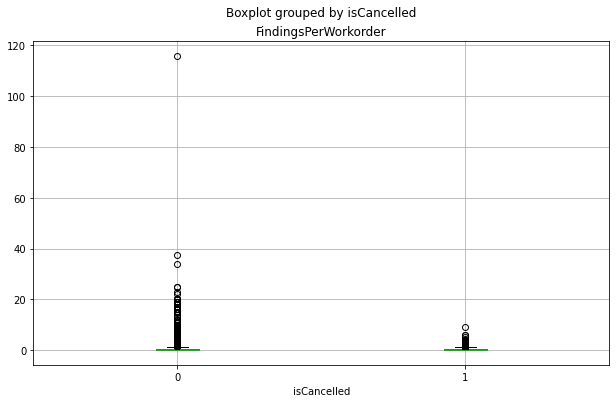

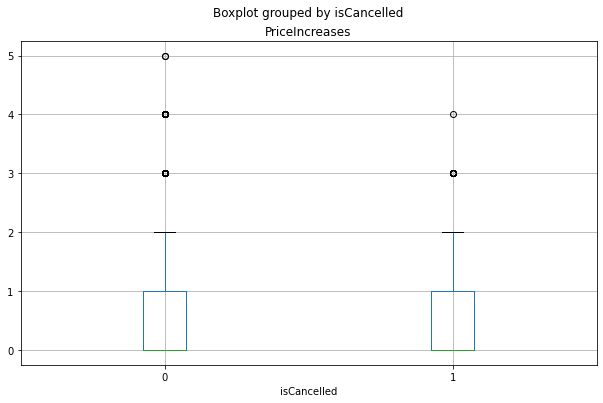

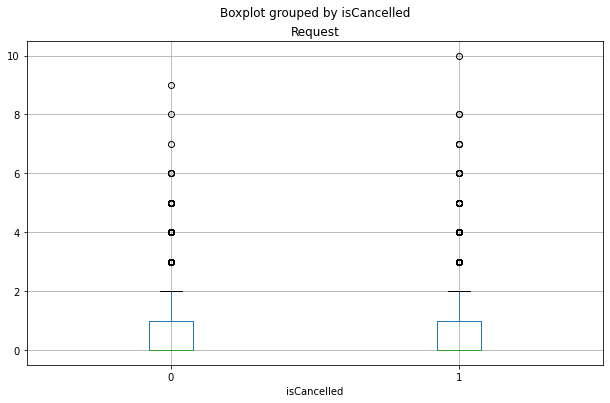

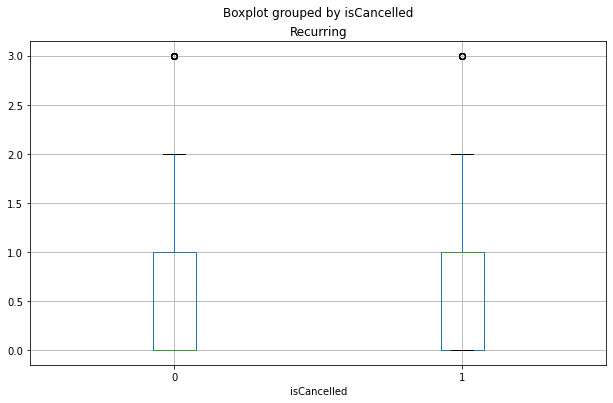

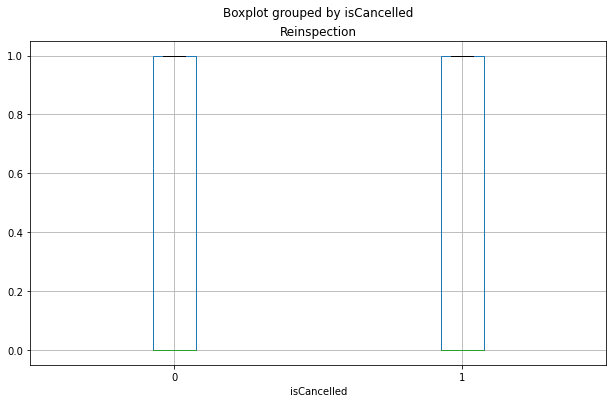

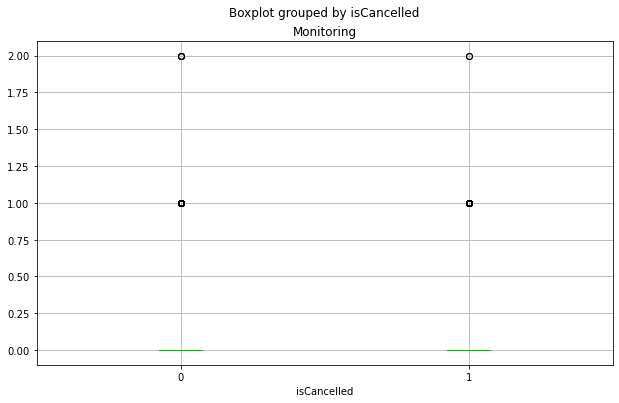

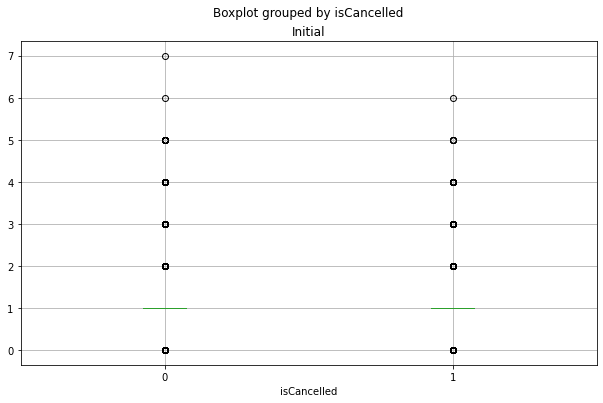

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


features = ['FindingsPerWorkorder','PriceIncreases','Request','Recurring','Reinspection','Monitoring','Initial']
# features = ['FindingsPerWorkorder','Request','PriceIncreases']
label = 'isCancelled'


X, y = cancelreasons[features].values, cancelreasons[label].values

print(X.shape)

X_new = SelectKBest(chi2, k=4).fit_transform(X, y)
print(X_new.shape)



# for col in features:
#     cancelreasons.boxplot(column=col, by='isCancelled', figsize=(10,6))
#     plt.title(col)
# plt.show()

Now let's compare the feature distributions for each label value.

For some of the features, there's a noticable difference in the distribution for each label value. In particular, **Pregnancies** and **Age** show markedly different distributions for diabetic patients than for non-diabetic patients. These features may help predict whether or not a patient is diabetic.

### Split the data

Our dataset includes known values for the label, so we can use this to train a classifier so that it finds a statistical relationship between the features and the label value; but how will we know if our model is any good? How do we know it will predict correctly when we use it with new data that it wasn't trained with? Well, we can take advantage of the fact we have a large dataset with known label values, use only some of it to train the model, and hold back some to test the trained model - enabling us to compare the predicted labels with the already known labels in the test set.

In Python, the **scikit-learn** package contains a large number of functions we can use to build a machine learning model - including a **train_test_split** function that ensures we get a statistically random split of training and test data. We'll use that to split the data into 70% for training and hold back 30% for testing.

In [6]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training cases: %d\nTest cases: %d' % (X_train.size, X_test.size))

Training cases: 2449888
Test cases: 1049958


### Train and Evaluate a Binary Classification Model
OK, now we're ready to train our model by fitting the training features (**X_train**) to the training labels (**y_train**). There are various algorithms we can use to train the model. In this example, we'll use *Logistic Regression*, which (despite its name) is a well-established algorithm for classification. In addition to the training features and labels, we'll need to set a *regularization* parameter. This is used to counteract any bias in the sample, and help the model generalize well by avoiding *overfitting* the model to the training data.

> **Note**: Parameters for machine learning algorithms are generally referred to as *hyperparameters* (to a data scientist, *parameters* are values in the data itself - *hyperparameters* are defined externally from the data!)

In [17]:
# Train the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)
print (model)
predictions = model.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, predictions))

LogisticRegression(C=100.0, solver='liblinear')
Accuracy:  0.706490432695513


Now we've trained the model using the training data, we can use the test data we held back to evaluate how well it predicts. Again, **scikit-learn** can help us do this. Let's start by using the model to predict labels for our test set, and compare the predicted labels to the known labels:

The accuracy is returned as a decimal value - a value of 1.0 would mean that the model got 100% of the predictions right; while an accuracy of 0.0 is, well, pretty useless!

Accuracy seems like a sensible metric to evaluate (and to a certain extent it is), but you need to be careful about drawing too many conclusions from the accuracy of a classifier. Remember that it's simply a measure of how many cases were predicted correctly. Suppose only 3% of the population is diabetic. You could create a classifier that always just predicts 0, and it would be 97% accurate - but not terribly helpful in identifying patients with diabetes!

Fortunately, there are some other metrics that reveal a little more about how our model is performing. Scikit-Learn includes the ability to create a *classification report* that provides more insight than raw accuracy alone.

In [90]:
from sklearn. metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.68      0.96      0.79    197988
           1       0.59      0.11      0.19    101992

    accuracy                           0.67    299980
   macro avg       0.64      0.54      0.49    299980
weighted avg       0.65      0.67      0.59    299980



The classification report includes the following metrics for each class  (0 and 1)

> note that the header row may not line up with the values!

* *Precision*: Of the predictons the model made for this class, what proportion were correct?
* *Recall*: Out of all of the instances of this class in the test dataset, how many did the model identify?
* *F1-Score*: An average metric that takes both precision and recall into account.
* *Support*: How many instances of this class are there in the test dataset?

The classification report also icludes averages for these metrics, including a weighted average that allows for the imbalance in the number of cases of each class.

Because this is a *binary* classification problem, the ***1*** class is considered *positive* and its precision and recall are particularly interesting - these in effect answer the questions:

- Of all the patients the model predicted are diabetic, how many are actually diabetic?
- Of all the ptients that are actually diabetic, how many did the model identify?

You can retrieve these values on their own by using the **precision_score** and **recall_score** metrics in scikit-learn (which by default assume a binary classification model).

In [69]:
from sklearn.metrics import precision_score, recall_score

print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))

Overall Precision: 0.5978692643487781
Overall Recall: 0.4176209898815593


The precision and recall metrics are derived from four possible prediction outcomes:
* *True Positives*: The predicted label and the actual label are both 1.
* *False Positives*: The predicted label is 1, but the actual label is 0.
* *False Negatives*: The predicted label is 0, but the actual label is 1.
* *True Negatives*: The predicted label and the actual label are both 0.

These metrics are generally tabulated for the test set and shown together as a *confusion matrix*, which takes the following form:

<table style="border: 1px solid black;">
    <tr style="border: 1px solid black;">
        <td style="border: 1px solid black;color: black;" bgcolor="lightgray">TN</td><td style="border: 1px solid black;color: black;" bgcolor="white">FP</td>
    </tr>
    <tr style="border: 1px solid black;">
        <td style="border: 1px solid black;color: black;" bgcolor="white">FN</td><td style="border: 1px solid black;color: black;" bgcolor="lightgray">TP</td>
    </tr>
</table>

Note that the correct (*true*) predictions form a diagonal line from top left to bottom right - these figures should be significantly higher than the *false* predictions if the model is any good.

In Python, you can use the **sklearn.metrics.confusion_matrix** function to find these values for a trained classifier:

In [70]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
cm = confusion_matrix(y_test, predictions)
print (cm)

[[169339  28649]
 [ 59398  42594]]


Until now, we've considered the predictions from the model as being either 1 or 0 class labels. Actually, things are a little more complex than that. Statistical machine learning algorithms, like logistic regression, are based on *probability*; so what actually gets predicted by a binary classifier is the probability that the label is true (**P(y)**) and the probability that the label is false (1 - **P(y)**). A threshold value of 0.5 is used to decide whether the predicted label is a 1 (*P(y) > 0.5*) or a 0 (*P(y) <= 0.5*). You can use the **predict_proba** method to see the probability pairs for each case:

In [71]:
y_scores = model.predict_proba(X_test)
print(y_scores)

[[0.88442423 0.11557577]
 [0.65388765 0.34611235]
 [0.45872122 0.54127878]
 ...
 [0.45872122 0.54127878]
 [0.45847172 0.54152828]
 [0.45872122 0.54127878]]


The decision to score a prediction as a 1 or a 0 depends on the threshold to which the predicted probabilties are compared. If we were to change the threshold, it would affect the predictions; and therefore change the metrics in the confusion matrix. A common way to evaluate a classifier is to examine the *true positive rate* (which is another name for recall) and the *false positive rate* for a range of possible thresholds. These rates are then plotted against all possible thresholds to form a chart known as a *received operator characteristic (ROC) chart*, like this:

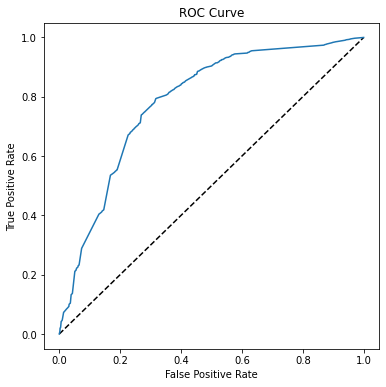

In [72]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The ROC chart shows the curve of the true and false positive rates for different threshold values between 0 and 1. A perfect classifier would have a curve that goes straight up the left side and straight across the top. The diagonal line across the chart represents the probability of predicting correctly with a 50/50 random prediction; so you obviously want the curve to be higher than that (or your model is no better than simply guessing!).

The area under the curve (AUC) is a value between 0 and 1 that quantifies the overall performance of the model. The closer to 1 this value is, the better the model. Once again, scikit-Learn includes a function to calculate this metric.

In [73]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

AUC: 0.7840939975327811


### Perform preprocessing in a pipeline

In this case, the ROC curve and its AUC indicate that the model performs better than a random guess which is not bad considering we performed very little preprocessing of the data.

In practice, it's common to perform some preprocessing of the data to make it easier for the algorithm to fit a model to it. There's a huge range of preprocessing trasformations you can perform to get your data ready for modeling, but we'll limit ourselves to a few common techniques:

- Scaling numeric features so they're on the same scale. This prevents feaures with large values from producing coefficients that disproportionately affect the predictions.
- Encoding categorical variables. For example, by using a *one hot encoding* technique you can create individual binary (true/false) features for each possible category value.

To apply these preprocessing transformations, we'll make use of a Scikit-Learn feature named *pipelines*. These enable us to define a set of preprocessing steps that end with an algorithm. You can then fit the entire pipeline to the data, so that the model encapsulates all of the preprocessing steps as well as the regression algorithm. This is useful, because when we want to use the model to predict values from new data, we need to apply the same transformations (based on the same statistical distributions and catagory encodings used with the training data).

>**Note**: The term *pipeline* is used extensively in machine learning, often to mean very different things! In this context, we're using it to refer to pipeline objects in Scikit-Learn, but you may see it used elsewhere to mean someting else.


In [ ]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np

# Define preprocessing for numeric columns (normalize them so they're on the same scale)
numeric_features = [0,1,2,3,4,5,6]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode the Age column)
categorical_features = [7]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', LogisticRegression(C=1/reg, solver="liblinear"))])


# fit the pipeline to train a logistic regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

The pipeline encapsulates the preprocessing steps as well as model training.

Let's use the model trained by this pipeline to predict labels for our test set, and compare the performance metrics with the basic model we created previously.

In [ ]:
# Get predictions from test data
predictions = model.predict(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

# calculate ROC curve
y_scores = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()



The results look a little better, so clearly preprocessing the data has made a difference.

### Try a different algorithm

Now let's try a different algorithm. Previously we used a logistic regression algorithm, which is a *linear* algorithm. There are many kinds of classification algorithm we could try, including:

- **Support Vector Machine algorithms**: Algorithms that define a *hyperplane* that separates classes.
- **Tree-based algorithms**: Algorithms that build a decision tree to reach a prediction
- **Ensemble algorithms**: Algorithms that combine the outputs of multiple base algorithms to improve generalizability.

This time, We'll use the same preprocessing steps as before, but we'll train the model using an *ensemble* algorithm named *Random Forest* that combines the outputs of multiple random decision trees (for more details, see the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', RandomForestClassifier())])

# fit the pipeline to train a random forest model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Let's look at the performance metrics for the new model.

In [ ]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('\nAUC: ' + str(auc))

# calculate ROC curve
y_scores = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

That looks better!

### Use the Model for Inferencing
Now that we have a reasonably useful trained model, we can save it for use later to predict labels for new data:

In [ ]:
import joblib

# Save the model as a pickle file
filename = './models/diabetes_model.pkl'
joblib.dump(model, filename)

When we have some new observations for which the label is unknown, we can load the model and use it to predict values for the unknown label:

In [ ]:
# Load the model from the file
model = joblib.load(filename)

# predict on a new sample
# The model accepts an array of feature arrays (so you can predict the classes of multiple patients in a single call)
# We'll create an array with a single array of features, representing one patient
X_new = [[2,180,74,24,21,23.9091702,1.488172308,22]]
print ('New sample: {}'.format(list(X_new[0])))

# Get a prediction
pred = model.predict(X_new)

# The model returns an array of predictions - one for each set of features submitted
# In our case, we only submitted one patient, so our prediction is the first one in the resulting array.
print('Predicted class is {}'.format(pred[0]))

## Multiclass Classification

Binary classification techniques work well when the data observations belong to one of two classes or categories, such as "True" or "False". When the data can be categorized into more than two classes, you must use a multiclass classification algorithm.

Fortunately, in most machine learning frameworks, including scikit-learn, implementing a multiclass classifier is not significantly more complex than binary classification - and in many cases, the classification algorithm classes used for binary classification implicitly support multiclass classification.

### Explore the data

Let's start by examining a dataset that contains observations of multiple classes. We'll use a dataset that contains observations of three different species of penguin.

> **Citation**: The penguins dataset used in the this exercise is a subset of data collected and made available by [Dr. Kristen
Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php)
and the [Palmer Station, Antarctica LTER](https://pal.lternet.edu/), a
member of the [Long Term Ecological Research
Network](https://lternet.edu/).

In [ ]:
import pandas as pd

# load the training dataset
penguins = pd.read_csv('data/penguins.csv')

# Display a random sample of 10 observations
sample = penguins.sample(10)
sample

The dataset contains the following columns:
* **CulmenLength**: The length in mm of the penguin's culmen (bill).
* **CulmenDepth**: The depth in mm of the penguin's culmen.
* **FlipperLength**: The length in mm of the penguin's flipper.
* **BodyMass**: The body mass of the penguin in grams.
* **Species**: An integer value that represents the species of the penguin.

The **Species** column is the label we want to train a model to predict. The dataset includes three possible species, which are encoded as 0, 1, and 2. The actual species names are revealed by the code below:

In [ ]:
penguin_classes = ['Amelie', 'Gentoo', 'Chinstrap']
print(sample.columns[0:5].values, 'SpeciesName')
for index, row in penguins.sample(10).iterrows():
    print('[',row[0], row[1], row[2], row[3], int(row[4]),']',penguin_classes[int(row[4])])

Now that we know what the feaures and labels in the data represent, let's explore the dataset. First, let's see if there are any missing (*null*) values.

In [ ]:
# Count the number of null values for each column
penguins.isnull().sum()

It looks like there are some missing feature values, but no missing labels. Let's dig a little deeper and see the rows that contain nulls.

In [ ]:
# Show rows containing nulls
penguins[penguins.isnull().any(axis=1)]

There are two rows that contain no feature values at all (*NaN* stands for "not a number"), so these won't be useful in training a model. Let's discard them from the dataset.

In [ ]:
# Drop rows containing NaN values
penguins=penguins.dropna()
#Confirm there are now no nulls
penguins.isnull().sum()


Now that we've dealt with the missing values, let's explore how the features relate to the label by creating some box charts.

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

penguin_features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
penguin_label = 'Species'
for col in penguin_features:
    penguins.boxplot(column=col, by=penguin_label, figsize=(6,6))
    plt.title(col)
plt.show()

From the box plots, it looks like species 0 and 2 (Amelie and Chinstrap) have similar data profiles for culmen depth, flipper length, and body mass, but Chinstraps tend to have longer culmens. Species 1 (Gentoo) tends to have fairly clearly differentiated features from the others; which should help us train a good classification model.

### Prepare the data

Just as for binary classification, before training the model, we need to separate the features and label, and then split the data into subsets for training and validation. We'll also apply a *stratification* technique when splitting the data to maintain the proportion of each label value in the training and validation datasets.

In [ ]:
from sklearn.model_selection import train_test_split

# Separate features and labels
penguins_X, penguins_y = penguins[penguin_features].values, penguins[penguin_label].values

# Split data 70%-30% into training set and test set
x_penguin_train, x_penguin_test, y_penguin_train, y_penguin_test = train_test_split(penguins_X, penguins_y,
                                                                                    test_size=0.30,
                                                                                    random_state=0,
                                                                                    stratify=penguins_y)

print ('Training Set: %d, Test Set: %d \n' % (x_penguin_train.size, x_penguin_test.size))

### Train and evaluate a multiclass classifier

Now that we have a set of training features and corresponding training labels, we can fit a multiclass classification algorithm to the data to create a model. Most scikit-learn classification algorithms inherently supports multiclass classification. We'll try a logistic regression algorithm.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.1

# train a logistic regression model on the training set
multi_model = LogisticRegression(C=1/reg).fit(x_penguin_train, y_penguin_train)
print (multi_model)

Now we can use the trained model to predict the labels for the test features, and compare the predicted labels to the actual labels:

In [ ]:
penguin_predictions = multi_model.predict(x_penguin_test)
print('Predicted labels: ', penguin_predictions[:15])
print('Actual labels   : ' ,y_penguin_test[:15])

Let's look at a classification report.

In [ ]:
from sklearn. metrics import classification_report

print(classification_report(y_penguin_test, penguin_predictions))

As with binary classification, the report includes *precision* and *recall* metrics for each class. However, while with binary classification we could focus on the scores for the *positive* class; in this case, there are multiple classes so we need to look at an overall metric (either the macro or weighted average) to get a sense of how well the model performs across all three classes.

You can get the overall metrics separately from the report using the scikit-learn metrics score classes, but with multiclass results you must specify which average metric you want to use for precision and recall.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Overall Accuracy:",accuracy_score(y_penguin_test, penguin_predictions))
print("Overall Precision:",precision_score(y_penguin_test, penguin_predictions, average='macro'))
print("Overall Recall:",recall_score(y_penguin_test, penguin_predictions, average='macro'))

Now let's look at the confusion matrix for our model:

In [ ]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
mcm = confusion_matrix(y_penguin_test, penguin_predictions)
print(mcm)

The confusion matrix shows the intersection of predicted and actual label values for each class - in simple terms, the diagonal intersections from top-left to bottom-right indicate the number of correct predictions.

When dealing with multiple classes, it's generally more intuitive to visualize this as a heat map, like this:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Predicted Species")
plt.ylabel("True Species")
plt.show()

The darker squares in the confusion matrix plot indicate high numbers of cases, and you can hopefully see a diagonal line of darker squares indicating cases where the predicted and actual label are the same.

### Preprocess data in a pipeline

Again, just like with binary classification, you can use a pipeline to apply preprocessing steps to the data before fitting it to an algorithm to train a model. Let's see if we can improve the penguin predictor by scaling the numeric features in a transformation steps before training. We'll also try a different algorithm (a support vector machine), just to show that we can!

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Define preprocessing for numeric columns (scale them)
feature_columns = [0,1,2,3]
feature_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('preprocess', feature_transformer, feature_columns)])

# Create training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', SVC())])
                           #('regressor', LogisticRegression(C=1/reg))])


# fit the pipeline to train a linear regression model on the training set
multi_model = pipeline.fit(x_penguin_train, y_penguin_train)
print (multi_model)

Now we can evaluate the new model.

In [ ]:
# Get predictions from test data
penguin_predictions = multi_model.predict(x_penguin_test)

# Overall metrics
print("Overall Accuracy:",accuracy_score(y_penguin_test, penguin_predictions))
print("Overall Precision:",precision_score(y_penguin_test, penguin_predictions, average='macro'))
print("Overall Recall:",recall_score(y_penguin_test, penguin_predictions, average='macro'))

# Confusion matrix
plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Predicted Species")
plt.ylabel("True Species")
plt.show()

### Use the model with new data observations

Now let's save our trained model so we can use it again later.

In [ ]:
import joblib

# Save the model as a pickle file
filename = './models/penguin_model.pkl'
joblib.dump(multi_model, filename)

OK, so now we have a trained model. Let's use it to predict the class of a new penguin observation:

In [ ]:
# Load the model from the file
multi_model = joblib.load(filename)

# The model accepts an array of feature arrays (so you can predict the classes of multiple penguin observations in a single call)
# We'll create an array with a single array of features, representing one penguin
x_new = [[50.4,15.3,224,5550]]
print ('New sample: {}'.format(x_new[0]))

# The model returns an array of predictions - one for each set of features submitted
# In our case, we only submitted one penguin, so our prediction is the first one in the resulting array.
penguin_pred = multi_model.predict(x_new)[0]
print('Predicted class is', penguin_classes[penguin_pred])

You can also submit a batch of penguin observations to the model, and get back a prediction for each one.

In [ ]:
# This time our input is an array of two feature arrays
x_new = [[49.5,18.4,195, 3600],
         [38.2,20.1,190,3900]]
print ('New sample: {}'.format(x_new))

# Call the web service, passing the input data
predictions = multi_model.predict(x_new)

# Get the predicted classes.
for prediction in predictions:
    print(prediction, '(' + penguin_classes[prediction] +')')

## Learn More

Classification is one of the most common forms of machine learning, and by following the basic principles we've discussed in this notebook you should be able to train and evaluate classification models with scikit-learn. It's worth spending some time investigating classification algorithms in more depth, and a good starting point is the [Scikit-Learn documentation](https://scikit-learn.org/stable/user_guide.html).